# Tariff Analyzer Demonstration

This notebook demonstrates the key features of the Tariff Analyzer system.

In [38]:
import os
import json
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from IPython.display import HTML, display

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path to make imports work in notebook
sys.path.append('..')

In [39]:
try:
    import cartopy
    print("Cartopy is installed and available")
except ImportError:
    print("Cartopy is not installed. Install with: pip install cartopy")

Cartopy is installed and available


## Import Components

First, let's import the main components of the system:

In [40]:
from src.preprocessing.processor import TariffProcessor
from src.analysis.statistics import TariffStatistics
from src.analysis.time_series import TariffTimeSeriesAnalyzer
from src.analysis.network import TariffNetworkAnalyzer
from src.analysis.impact import TariffImpactAnalyzer
from src.visualization.dashboard import TariffDashboard
from src.visualization.geo_viz import GeoVisualizer
from src.visualization.network_viz import NetworkVisualizer
from src.visualization.time_viz import TimeVisualizer

## Load and Preprocess Data

Now, let's load the sample data and process it:

In [41]:
# Set up paths
sample_data_path = "../data/reference/event_api_response_example.json"
country_codes_path = "../data/reference/country_codes_iso_3166_1_alpha_2_code.csv"

# Load sample data
with open(sample_data_path, 'r') as f:
    data = json.load(f)

# Initialize processor
processor = TariffProcessor(country_codes_path)

# Process the data
processed_data = processor.process(data)

print(f"Processed {len(processed_data['events'])} events")
print(f"Metadata: {processed_data['metadata']}")

2025-03-08 02:59:20,787 - INFO - Loaded 252 country mappings
2025-03-08 02:59:20,788 - INFO - Loaded 252 country mappings
2025-03-08 02:59:20,788 - INFO - Processing 1 tariff events
2025-03-08 02:59:20,789 - INFO - Created bit mapping for affected_industries with 3 unique values
2025-03-08 02:59:20,789 - INFO - Created bit mapping for hs_product_categories with 3 unique values
2025-03-08 02:59:20,790 - INFO - Created bit mapping for affected_products with 4 unique values
2025-03-08 02:59:20,791 - INFO - Processing batch 1/1
2025-03-08 02:59:20,792 - INFO - Processing complete. 1 events processed, 0 duplicates removed.
Processed 1 events
Metadata: {'original_count': 1, 'processed_count': 1, 'duplicates_removed': 0, 'processing_time': 0.00384521484375, 'relationship_stats': {'total_relationships': 2, 'relationships': {'US_CN': 1, 'US_KR': 1}, 'total_retaliations': 0, 'retaliations': {}}}


## Statistical Analysis

Let's analyze the processed data:

In [42]:
# Statistical analysis
stats = TariffStatistics(processed_data)
summary = stats.get_summary_statistics()

# Display key statistics
print(f"Total events: {summary['total_events']}")
print(f"Rate statistics: {summary.get('rate_statistics', {})}")
print("\nTop imposing countries:")
for country in summary.get('top_imposing_countries', []):
    print(f"- {country['name']}: {country['count']} events")

Total events: 1
Rate statistics: {'count': np.int64(1), 'mean': np.float64(35.0), 'median': 35.0, 'min': 35, 'max': 35, 'std': nan}

Top imposing countries:
- US: 1 events


## Rate Distribution

Let's look at the distribution of tariff rates:

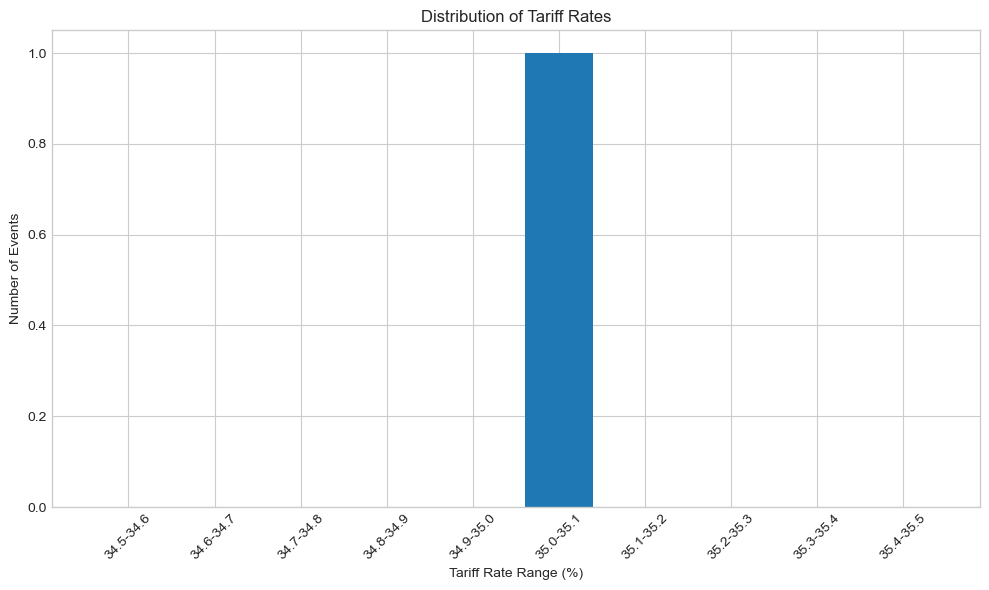

In [43]:
# Get rate distribution
rate_distribution = stats.get_rate_distribution()

# Plot distribution
plt.figure(figsize=(10, 6))
plt.bar(rate_distribution["bins"], rate_distribution["counts"])
plt.xlabel("Tariff Rate Range (%)")
plt.ylabel("Number of Events")
plt.title("Distribution of Tariff Rates")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Impact Analysis

Now, let's analyze the economic impact:

,industry,event_count,avg_rate,vulnerability
0,Information Technology,1,35.0,0.74
1,Consumer Discretionary,1,35.0,0.74
2,Materials,1,35.0,0.74


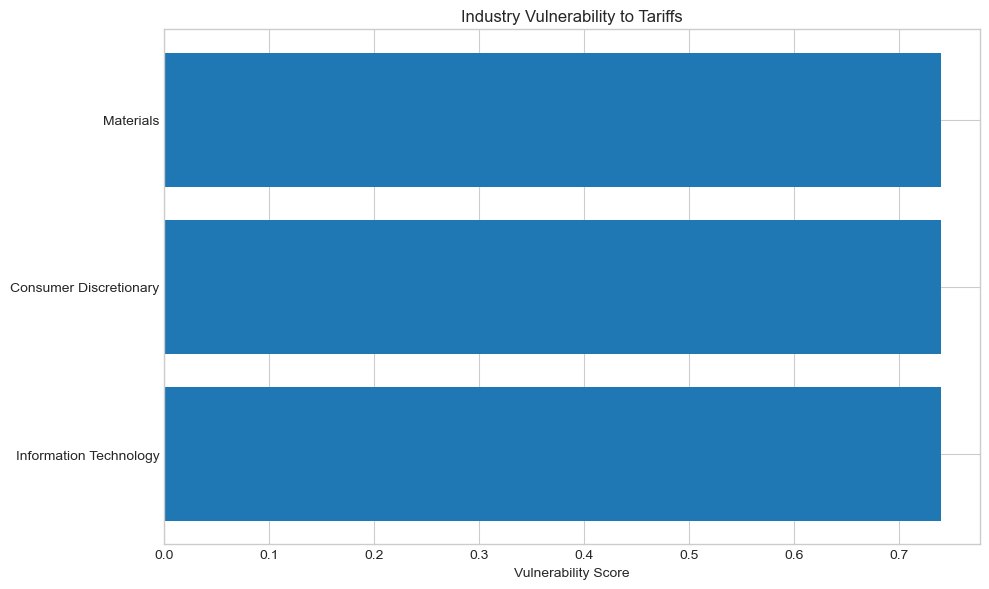

In [44]:
# Impact analysis
impact = TariffImpactAnalyzer(processed_data)

# Get industry impact
industry_impact = impact.get_industry_impact_assessment()

if "error" not in industry_impact:
    # Convert to DataFrame for easier viewing
    industry_df = pd.DataFrame(industry_impact["industries"])
    
    # Sort by vulnerability
    industry_df = industry_df.sort_values("vulnerability", ascending=False)
    
    # Display as table
    display(industry_df[['industry', 'event_count', 'avg_rate', 'vulnerability']])
    
    # Bar chart of industry vulnerability
    plt.figure(figsize=(10, 6))
    plt.barh(industry_df['industry'], industry_df['vulnerability'])
    plt.xlabel('Vulnerability Score')
    plt.title('Industry Vulnerability to Tariffs')
    plt.tight_layout()
    plt.show()
else:
    print(f"Could not analyze industry impact: {industry_impact['error']}")

## Country Impact Analysis

In [45]:
# Get country impact
country_impact = impact.get_country_impact_assessment()

if "error" not in country_impact:
    # Convert to DataFrame for easier viewing
    country_df = pd.DataFrame(country_impact["countries"])
    
    # Sort by targeted count
    country_df = country_df.sort_values("targeted_count", ascending=False).head(10)
    
    # Display as table
    display(country_df[['country', 'targeted_count', 'imposing_count', 'net_position']])
else:
    print(f"Could not analyze country impact: {country_impact['error']}")

,country,targeted_count,imposing_count,net_position
0,CN,1,0,-1
1,KR,1,0,-1
2,US,0,1,1


## Time Series Analysis

Let's look at the temporal patterns in the data:

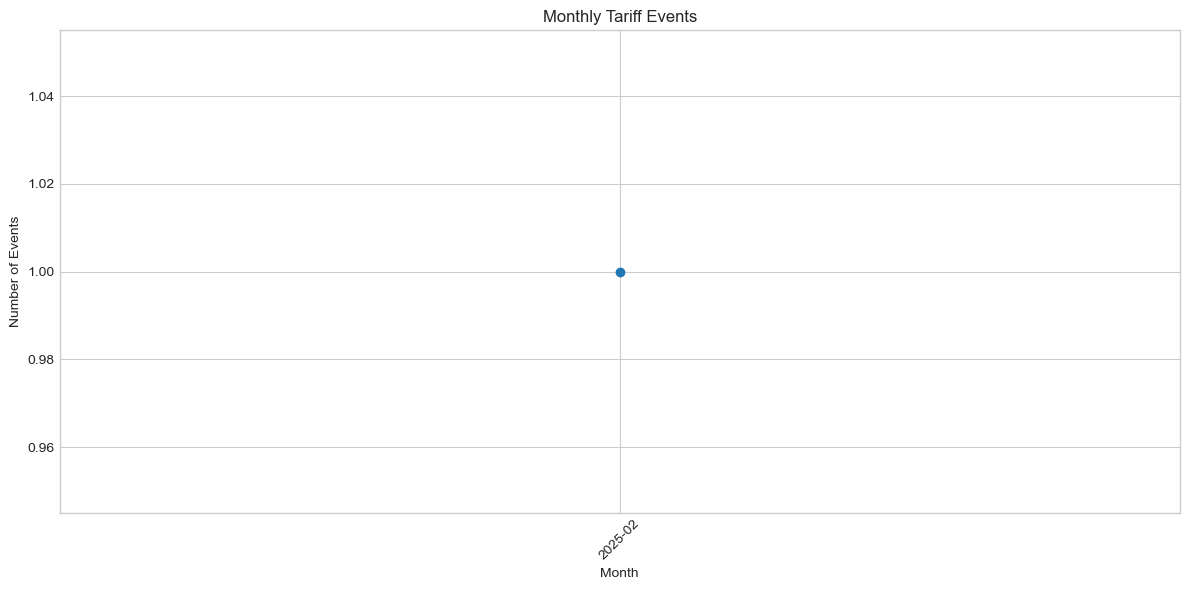

In [46]:
# Time series analysis
time_analyzer = TariffTimeSeriesAnalyzer(processed_data)

# Get monthly event counts
monthly_counts = time_analyzer.get_monthly_event_counts()

if "error" not in monthly_counts:
    # Plot monthly counts
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_counts["dates"], monthly_counts["counts"], marker='o')
    plt.xlabel("Month")
    plt.ylabel("Number of Events")
    plt.title("Monthly Tariff Events")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print(f"Could not analyze monthly counts: {monthly_counts['error']}")

## Network Analysis

Now, let's analyze the trade relationships as a network:

In [47]:
# Network analysis
network_analyzer = TariffNetworkAnalyzer(processed_data)

# Get network summary
network_summary = network_analyzer.get_network_summary()

if "error" not in network_summary:
    print(f"Network summary:")
    print(f"- Nodes: {network_summary['nodes']}")
    print(f"- Edges: {network_summary['edges']}")
    print(f"- Density: {network_summary['density']:.4f}")
    
    if "centrality" in network_summary:
        print("\nTop countries by centrality:")
        for country in network_summary["centrality"]["top_imposing"]:
            print(f"- {country['country']}: {country['score']:.3f}")
else:
    print(f"Could not analyze network: {network_summary['error']}")

2025-03-08 02:59:28,573 - INFO - Built graph with 3 nodes and 2 edges
Network summary:
- Nodes: 3
- Edges: 2
- Density: 0.3333

Top countries by centrality:
- US: 1.000
- CN: 0.000
- KR: 0.000


## Visualizations

Let's create and display some visualizations:

In [48]:
# Initialize visualizers
time_viz = TimeVisualizer(processed_data)
geo_viz = GeoVisualizer(processed_data, country_codes_path)
network_viz = NetworkVisualizer(processed_data)

# Create visualizations
monthly_trend = time_viz.plot_monthly_trend()
seasonal_pattern = time_viz.plot_seasonal_pattern()
world_map = geo_viz.plot_tariff_world_map()
network_graph = network_viz.plot_tariff_network()

2025-03-08 02:59:29,818 - WARNING - No country code file provided, using limited mappings
2025-03-08 02:59:29,823 - WARNING - No country code file provided, using limited mappings
2025-03-08 02:59:29,833 - WARNING - No valid coordinates loaded from file
2025-03-08 02:59:29,834 - INFO - Using default country coordinates
2025-03-08 02:59:29,835 - WARNING - No country code file provided, using limited mappings
2025-03-08 02:59:29,837 - INFO - Built network graph with 3 nodes and 2 edges
2025-03-08 02:59:29,992 - ERROR - Error creating world map visualization: name 'sys' is not defined


### Monthly Trend Visualization


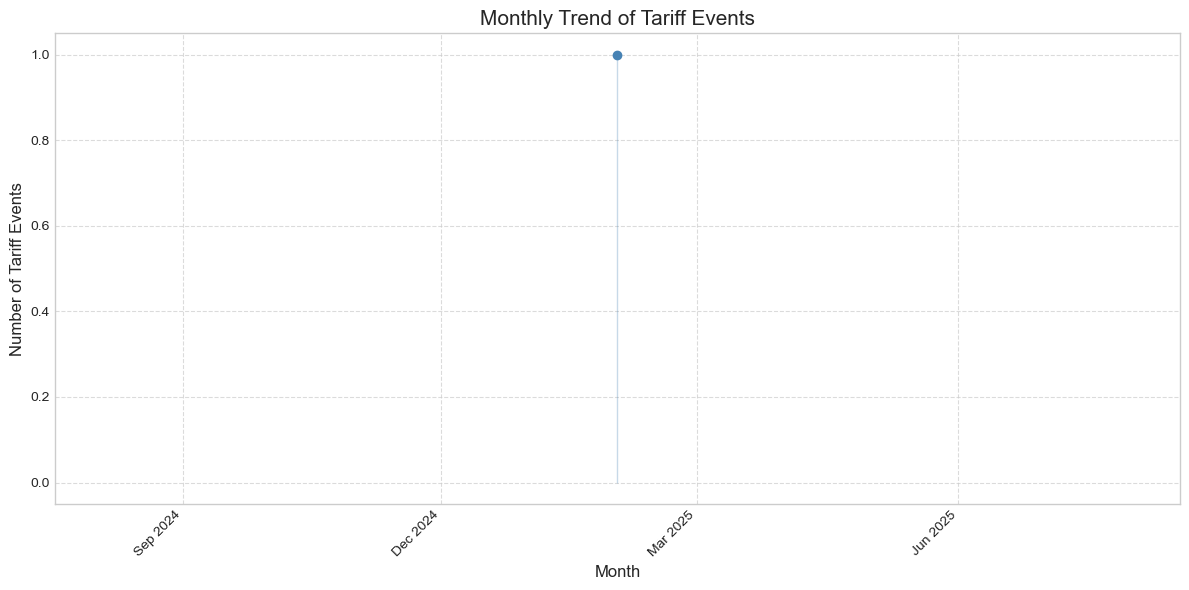

In [49]:
if monthly_trend:
    display(HTML(f'<img src="data:image/png;base64,{monthly_trend}" width="800">'))  
else:
    print("No monthly trend visualization available")

### Seasonal Pattern Visualization


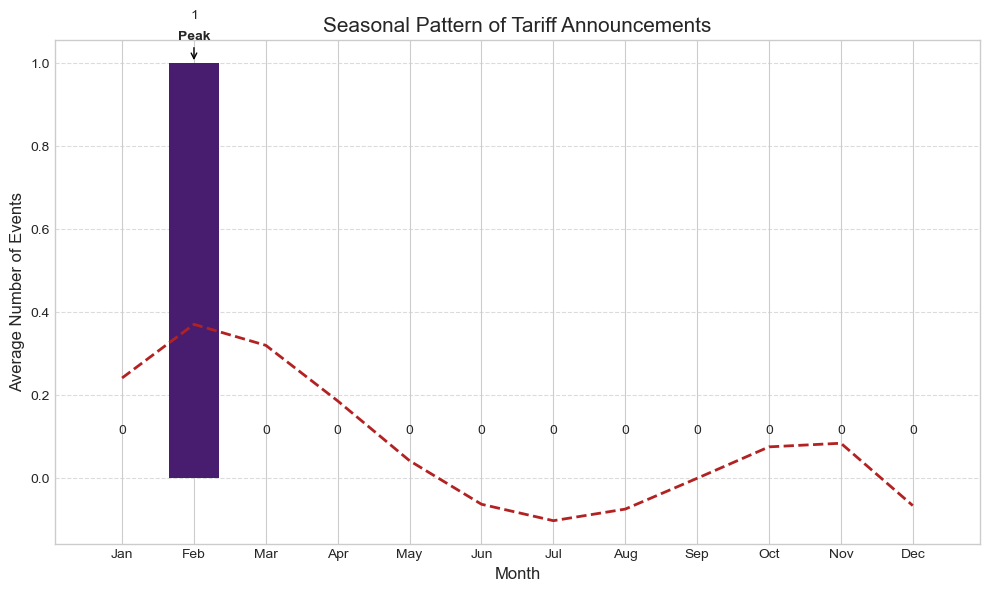

In [50]:
if seasonal_pattern:
    display(HTML(f'<img src="data:image/png;base64,{seasonal_pattern}" width="800">'))  
else:
    print("No seasonal pattern visualization available")

### World Map Visualization


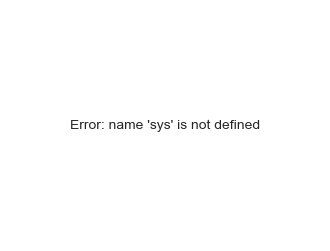

In [51]:
if world_map:
    display(HTML(f'<img src="data:image/png;base64,{world_map}" width="800">'))  
else:
    print("No world map visualization available")

### Network Graph Visualization


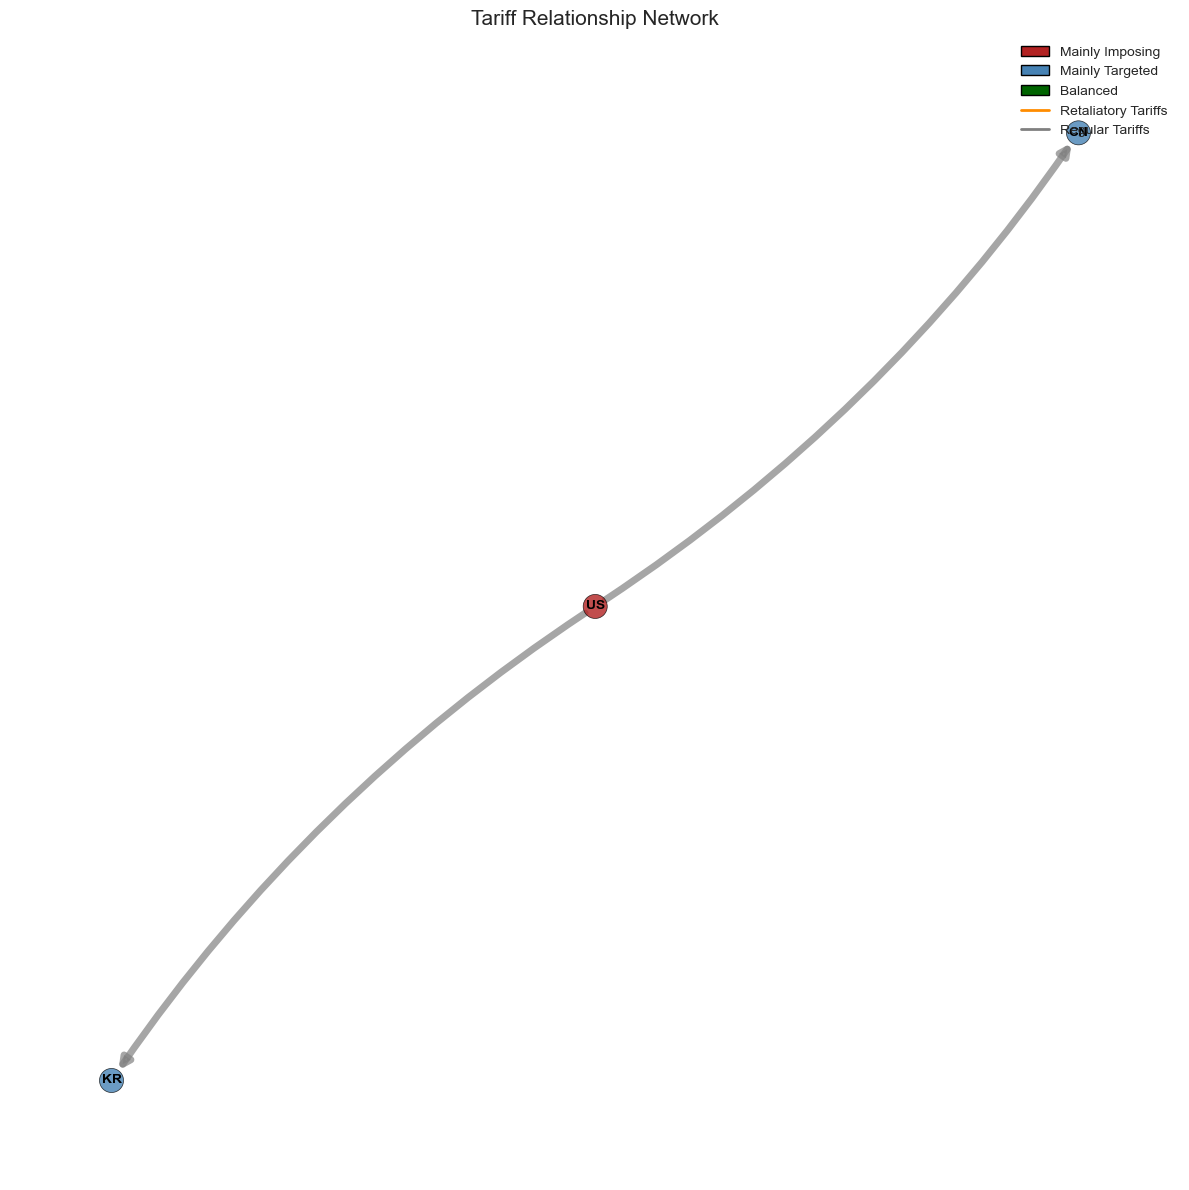

In [14]:
if network_graph:
    display(HTML(f'<img src="data:image/png;base64,{network_graph}" width="800">'))  
else:
    print("No network graph visualization available")

## Generate Dashboard

Finally, let's generate a comprehensive dashboard:

2025-03-08 02:38:17,334 - WARNING - No country code file provided, using limited mappings
2025-03-08 02:38:17,698 - INFO - Dashboard saved to ../output/notebook_dashboard.html
Dashboard generated at: ../output/notebook_dashboard.html
Open this file in a web browser to view the complete dashboard.


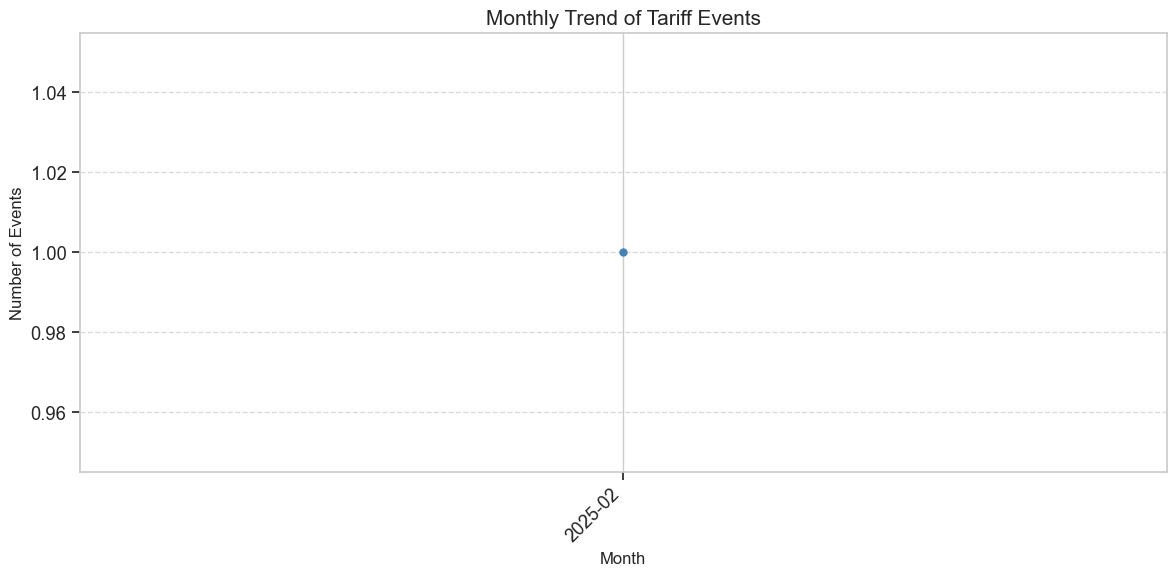

In [15]:
# Create dashboard
dashboard = TariffDashboard(processed_data)

# Generate HTML
html_path = "../output/notebook_dashboard.html"
dashboard.generate_dashboard_html(html_path)

print(f"Dashboard generated at: {html_path}")
print("Open this file in a web browser to view the complete dashboard.")

## Summary

In this notebook, we've demonstrated the main components of the Tariff Analyzer system:

1. **Preprocessing**: Loading and processing raw tariff data
2. **Analysis**: Statistical, impact, time series, and network analysis
3. **Visualization**: Creating visualizations of the analysis results

The system provides a comprehensive toolkit for analyzing tariff data and understanding trade relationships and impacts.